In [1]:
import lightgbm as lgb # 需要安装
import catboost as cat # 需要安装
import pandas as pd
import xgboost as xgb # 需要安装
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")
import os

In [28]:
def prepare(df):
    global json_cols
    global train_dict
    
    #print(df.loc[3010,'title'])
    
    #时间相关
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 19) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 19)  & (df['release_year'] < 100), "release_year"] += 1900
    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek 
    df['release_quarter'] = releaseDate.dt.quarter 
    
    
    #用相同年份和语言的平均评分填补评分的缺失
    df.loc[df['rating']==0,'rating']=np.nan   #首先，没有评分的我们认为就是缺失
    rating_na = df.groupby(["release_year","original_language"])['rating'].mean().reset_index()
    df=df.merge(rating_na, how = 'left' ,on = ["release_year","original_language"])
    for i in range(df.shape[0]):
        if np.isnan(df.loc[i]['rating_x']):
            df.loc[i,'rating_x']=df.loc[i,'rating_y']
    #其实这样还有一些没有补全，我们用总体均值补全
    m=df['rating_x'].mean()
    df['rating_x'].fillna(m,inplace=True)
    df['rating']=df['rating_x']
    df=df.drop(['rating_x','rating_y'],axis=1)
    #至此，评分补全了
    
    
    
    #用相同方法处理runtime的缺失
    df.loc[df['runtime']==0,'runtime']=np.nan   #首先，没有时间的我们认为就是缺失
    runtime_na=df.groupby(["release_year","original_language"])['runtime'].mean().reset_index()
    df=df.merge(runtime_na, how = 'left' ,on = ["release_year","original_language"])
    for i in range(df.shape[0]):
        if np.isnan(df.loc[i]['runtime_x']):
            df.loc[i,'runtime_x']=df.loc[i,'runtime_y']
    #其实这样还有一些没有补全，我们用总体均值补全
    m=df['runtime_x'].mean()
    df['runtime_x'].fillna(m,inplace=True)
    df['runtime']=df['runtime_x']
    df=df.drop(['runtime_x','runtime_y'],axis=1)
    #至此，时长补全了
    #print(df.loc[391,'runtime'])
    
    
    
    '''
    #同样的方式填补评分人数，评分人数可以为零
    vote_count_na = df.groupby(["release_year","original_language"])['totalVotes'].mean().reset_index()
    df = df.merge(vote_count_na, how = 'left' ,on = ["release_year","original_language"])
    for i in range(df.shape[0]):
        if np.isnan(df.loc[i]['totalVotes_x']):
            df.loc[i,'totalVotes_x']=df.loc[i,'totalVotes_y']
    #其实这样还有一些没有补全，我们用总体均值补全
    m=df['totalVotes_x'].mean()
    df['totalVotes_x'].fillna(m,inplace=True)
    df['totalVotes']=df['totalVotes_x']
    df=df.drop(['totalVotes_x','totalVotes_y'],axis=1)
    #至此，评分人数补全了，最后记得删除totalVotes_y
    '''
    
    
    '''
    #popularity2也需要补全，后面可以看看直接去掉会怎么影响
    #使用当年的平均popularity2补全
    df['mean_popularity2']=df.groupby("release_year")["popularity2"].transform('mean')
    for i in range(df.shape[0]):
        if np.isnan(df.loc[i]['popularity2']):
            df.loc[i,'popularity2']=df.loc[i,'mean_popularity2']
    m=df['popularity2'].mean()
    df['popularity2'].fillna(m,inplace=True)
    df=df.drop(['mean_popularity2'],axis=1)
    '''
    
    
    
    df['weightedRating'] = ( df['rating']*df['totalVotes'] + 6.367 * 1000 ) / ( df['totalVotes'] + 1000 )


    df['originalBudget'] = df['budget']
    df['inflationBudget'] = df['budget'] + df['budget']*1.8/100*(2018-df['release_year']) #Inflation simple formula
    df['budget'] = np.log1p(df['budget']) 
    
    
    
    # Thanks to this Kernel for the next 7 features https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
    
    df['_collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    le = LabelEncoder()
    le.fit(list(df['_collection_name'].fillna('')))
    df['_collection_name'] = le.transform(df['_collection_name'].fillna('').astype(str))
    
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)

    
    
    df['_popularity_mean_year'] = df['popularity'] / df.groupby("release_year")["popularity"].transform('mean')
    df['_budget_runtime_ratio'] = df['budget']/df['runtime']   #这个有nan！
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']

    df['_popularity_totalVotes_ratio'] = df['totalVotes']/df['popularity']
    df['_rating_popularity_ratio'] = df['rating']/df['popularity']
    df['_rating_totalVotes_ratio'] = df['totalVotes']/df['rating']
    df['_totalVotes_releaseYear_ratio'] = df['totalVotes']/df['release_year']
    df['_budget_rating_ratio'] = df['budget']/df['rating']
    df['_runtime_rating_ratio'] = df['runtime']/df['rating']
    df['_budget_totalVotes_ratio'] = df['budget']/(df['totalVotes']+1)   #totalVotes可以为零，我们加1平滑
    
    df['has_homepage'] = 1
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 0
    
    df['isbelongs_to_collectionNA'] = 0
    df.loc[pd.isnull(df['belongs_to_collection']) ,"isbelongs_to_collectionNA"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    # get collection id
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    #df['overview_word_count'] = df['overview'].str.split().str.len()
    df['overview_word_count'] = df['overview'].apply(lambda x:len(x.split()) if not pd.isna(x) else 0)
    #df['tagline_word_count'] = df['tagline'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].apply(lambda x:len(x.split()) if not pd.isna(x) else 0)
    
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))
    

    #'''
    #这些属性应该没什么用
    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')   #这是什么?这些好像没什么用？
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')
    df['meantotalVotesByYear'] = df.groupby("release_year")["totalVotes"].aggregate('mean')
    df['meanTotalVotesByRating'] = df.groupby("rating")["totalVotes"].aggregate('mean')
    df['medianBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('median')
    #'''

    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    df = df.drop(['id', 'revenue','belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 
    
    '''
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if np.isinf(df.iloc[i,j]):
                df.iloc[i,j]=0.0
    '''

    return df

In [16]:
def ProcessDate(s):
    l=s.split('/')
    tmp=l[0]
    l[0]=l[1]
    l[1]=tmp
    return '/'.join(l)
ProcessDate('31/08/1956')

'08/31/1956'

In [17]:
train = pd.read_csv('../data/train.csv')

#ower_six = train.id[train.budget > 1000][train.revenue < 100]

#for k in power_six :
#    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000
#Clean Datapower_six 

#完善数据，这些不知道哪来的 
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

test = pd.read_csv('../data/test.csv')
#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

#ok，现在得到了train和test
test['revenue'] = np.nan   #需要预测的东西
print(train.shape)
print(test.shape)
print(train.info())

#增加额外数据
# features from https://www.kaggle.com/kamalchhirang/eda-simple-feature-engineering-external-data
train = pd.merge(train, pd.read_csv('../data/TrainAdditionalFeatures.csv'), how='left', on=['imdb_id'])
test = pd.merge(test, pd.read_csv('../data/TestAdditionalFeatures.csv'), how='left', on=['imdb_id'])

additionalTrainData = pd.read_csv('../data/additionalTrainData.csv')
additionalTrainData['release_date'] = additionalTrainData['release_date'].astype('str')
additionalTrainData['release_date'] = additionalTrainData['release_date'].str.replace('-', '/')
additionalTrainData['release_date'] = additionalTrainData['release_date'].apply(lambda x:ProcessDate(x))
train = pd.concat([train, additionalTrainData])

print(train.shape)
print(test.shape)
print(train.info())

train['revenue'] = np.log1p(train['revenue'])
y = train['revenue'].values

json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
#print(train['revenue'])

(3000, 23)
(4398, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object

In [18]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

for col in tqdm(json_cols + ['belongs_to_collection']) :
    train[col] = train[col].apply(lambda x : get_dictionary(x))
    test[col] = test[col].apply(lambda x : get_dictionary(x))

def get_json_dict(df) :
    global json_cols
    result = dict()
    for e_col in json_cols :
        d = dict()
        rows = df[e_col].values
        for row in rows :
            if row is None : continue
            for i in row :
                if i['name'] not in d :
                    d[i['name']] = 0
                d[i['name']] += 1
        result[e_col] = d
    return result

train_dict = get_json_dict(train)
test_dict = get_json_dict(test)
#print(train_dict)


# remove cateogry with bias and low frequency
for col in json_cols :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys())) 
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
            
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]

all_data = prepare(pd.concat([train, test]).reset_index(drop = True))
train = all_data.loc[:train.shape[0] - 1,:]
test = all_data.loc[train.shape[0]:,:] 

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.32s/it]


In [5]:
all_data

,budget,popularity,popularity2,rating,totalVotes,release_month,release_day,release_year,release_dayofweek,release_quarter,...,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
0,16.454568,6.575393,10.400,5.0,482.0,2,20,2015,4.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1,17.504390,8.248895,15.229,6.4,1528.0,8,6,2004,4.0,3.0,...,0,0,0,0,1,0,0,0,0,0
2,15.009433,64.299990,26.082,8.4,7314.0,10,10,2014,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
3,13.997833,3.174936,5.531,7.5,115.0,3,9,2012,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,1.148070,0.000,0.0,0.0,2,5,2009,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9394,17.553180,9.970359,12.843,5.9,358.0,8,3,2001,4.0,3.0,...,0,0,0,0,0,0,0,0,0,1
9395,16.759950,6.046516,6.584,5.4,312.0,8,20,2004,4.0,3.0,...,0,0,0,0,0,0,0,0,0,1
9396,16.588099,9.596883,5.582,7.5,219.0,12,8,1982,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
9397,14.508658,20.359336,18.117,6.5,3244.0,2,4,2015,2.0,1.0,...,0,0,0,0,0,0,0,0,0,1


## 三种Boost

In [19]:
from sklearn.model_selection import KFold

random_seed = 2021
k = 10
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(train))
np.random.seed(random_seed)

XGBoost

In [20]:
def xgb_model(trn_x, trn_y, val_x, val_y, test, features, verbose) :
    
    params = {'objective': 'reg:squarederror',
              'eta': 0.02,               # 默认0.3，典型值：0.01-0.2，学习率
              'max_depth': 6,            # 默认6，典型值：3-10，树的深度，树越深越能学到局部细节
              'subsample': 0.6,          # 默认1，典型值：0.5-1，每棵树随机采样的比例，减小这个参数的值避免过拟合
              'colsample_bytree': 0.7,   # 默认1，典型值：0.5-1，树的每一级的每一次分裂对列数的采样的占比，效果同上
              'eval_metric': 'rmse',     # 损失函数，均方根
              'seed': random_seed,       # 随机数2021
              #'silent': True,           # 不输出日志信息
    }
    
    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(trn_x, trn_y)
                      , 100000
                      , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks = [xgb.callback.record_evaluation(record)])
    score = model.get_score()
    importance = np.zeros(len(features),dtype=int)
    for k, i in score.items():
        importance[features.index(k)]=i
    best_idx = np.argmin(np.array(record['valid']['rmse']))

    val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)

    return {'val':val_pred, 'test':test_pred, 'error':record['valid']['rmse'][best_idx], 'importance':importance}

XGBoost model
---------------------------
1 fold.  RMSE: 2.21703 (25s)
2 fold.  RMSE: 2.03464 (26s)
3 fold.  RMSE: 2.35416 (32s)
4 fold.  RMSE: 2.32659 (34s)
5 fold.  RMSE: 2.29148 (24s)
6 fold.  RMSE: 1.94554 (56s)
7 fold.  RMSE: 2.43510 (22s)
8 fold.  RMSE: 2.00687 (23s)
9 fold.  RMSE: 2.21188 (27s)
10 fold.  RMSE: 1.99785 (39s)
---------------------------
fianl avg err. 2.18211 (313s)


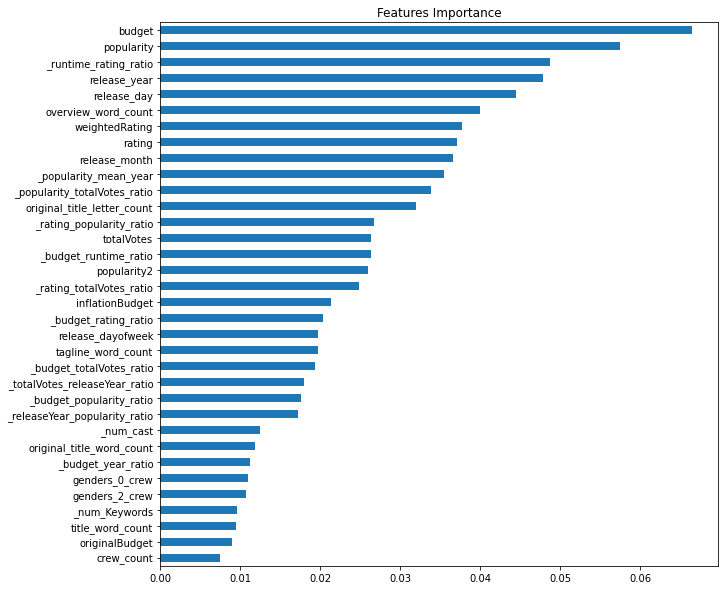

In [21]:
final_err = 0
features = list(train.columns)
feature_importance = pd.DataFrame(index=features)
val_pred = []
val_gold = []
test_pred = pd.DataFrame()

print("XGBoost model")
print("---------------------------")

begin = datetime.now()
for i, (trn, val) in enumerate(fold) :
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_err = []
    
    start = datetime.now()
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, features, verbose=False)
    fold_err.append(result['error'])
    val_pred += list(result['val'])
    val_gold += list(val_y)
    test_pred['fold' + str(i+1)] = result['test']
    feature_importance['fold' + str(i+1)] = result['importance'] / result['importance'].sum()
    print(i + 1, "fold.  RMSE:", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds)) + 's)')
    
    final_err += (sum(fold_err) / len(fold_err))
    
print("---------------------------")
print("fianl avg err.", "{0:.5f}".format(final_err / k), '(' + str(int((datetime.now()-begin).seconds)) + 's)')

val_data = pd.DataFrame({"val_pred":val_pred,"val_gold":val_gold})
val_data.to_csv("XGBoost_val.csv")
test_pred['avg'] = test_pred.mean(axis=1)
test_pred.to_csv("XGBoost_test.csv")
feature_importance['avg'] = feature_importance.mean(axis=1)
feature_importance.mean(axis=1).sort_values()[170:].plot(kind="barh",title = "Features Importance", figsize = (10,10))
feature_importance.to_csv("XGBoost_feature_importance.csv")

LightGBM

In [22]:
def lgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,              # 6是最好的
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

LightGBM model
---------------------------
1 fold.  RMSE: 2.23953 (11s)
2 fold.  RMSE: 2.04211 (12s)
3 fold.  RMSE: 2.39003 (28s)
4 fold.  RMSE: 2.33193 (21s)
5 fold.  RMSE: 2.32670 (11s)
6 fold.  RMSE: 1.95255 (15s)
7 fold.  RMSE: 2.41724 (15s)
8 fold.  RMSE: 1.98405 (13s)
9 fold.  RMSE: 2.22110 (20s)
10 fold.  RMSE: 2.00626 (26s)
---------------------------
fianl avg err. 2.19115 (176s)


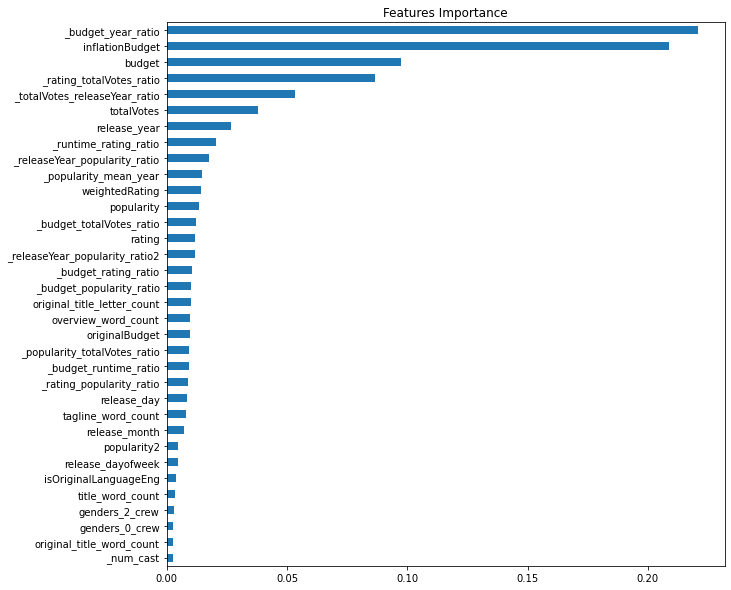

In [23]:
final_err = 0
features = list(train.columns)
feature_importance = pd.DataFrame(index=features)
val_pred = []
val_gold = []
test_pred = pd.DataFrame()

print("LightGBM model")
print("---------------------------")

begin = datetime.now()
for i, (trn, val) in enumerate(fold) :
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_err = []
    
    start = datetime.now()
    result = lgb_model(trn_x, trn_y, val_x, val_y, test, verbose=False)
    fold_err.append(result['error'])
    val_pred += list(result['val'])
    val_gold += list(val_y)
    test_pred['fold' + str(i+1)] = result['test']
    feature_importance['fold' + str(i+1)] = result['importance'] / result['importance'].sum()
    print(i + 1, "fold.  RMSE:", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds)) + 's)')
    
    final_err += (sum(fold_err) / len(fold_err))

print("---------------------------")
print("fianl avg err.", "{0:.5f}".format(final_err / k), '(' + str(int((datetime.now()-begin).seconds)) + 's)')

val_data = pd.DataFrame({"val_pred":val_pred,"val_gold":val_gold})
val_data.to_csv("LightGBM_val.csv")
test_pred['avg'] = test_pred.mean(axis=1)
test_pred.to_csv("LightGBM_test.csv")
feature_importance['avg'] = feature_importance.mean(axis=1)
feature_importance.mean(axis=1).sort_values()[170:].plot(kind="barh",title = "Features Importance", figsize = (10,10))
feature_importance.to_csv("LightGBM_feature_importance.csv")

CatBoost

In [24]:
from catboost import CatBoostRegressor
def cat_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    model = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = random_seed,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )
    model.fit(trn_x, trn_y,
                 eval_set=(val_x, val_y),
                 use_best_model=True,
                 verbose=False)
    
    val_pred = model.predict(val_x)
    test_pred = model.predict(test)
    
    return {'val':val_pred, 
            'test':test_pred, 
            'error':model.get_best_score()['validation']['RMSE'],
            'importance':model.feature_importances_}

CatBoost model
---------------------------
1 fold.  RMSE: 2.23535 (53s)
2 fold.  RMSE: 2.03196 (76s)
3 fold.  RMSE: 2.33189 (144s)
4 fold.  RMSE: 2.29281 (176s)
5 fold.  RMSE: 2.27655 (94s)
6 fold.  RMSE: 1.94855 (106s)
7 fold.  RMSE: 2.45315 (161s)
8 fold.  RMSE: 1.97296 (108s)
9 fold.  RMSE: 2.20859 (97s)
10 fold.  RMSE: 2.02573 (185s)
---------------------------
fianl avg err. 2.17775 (1204s)


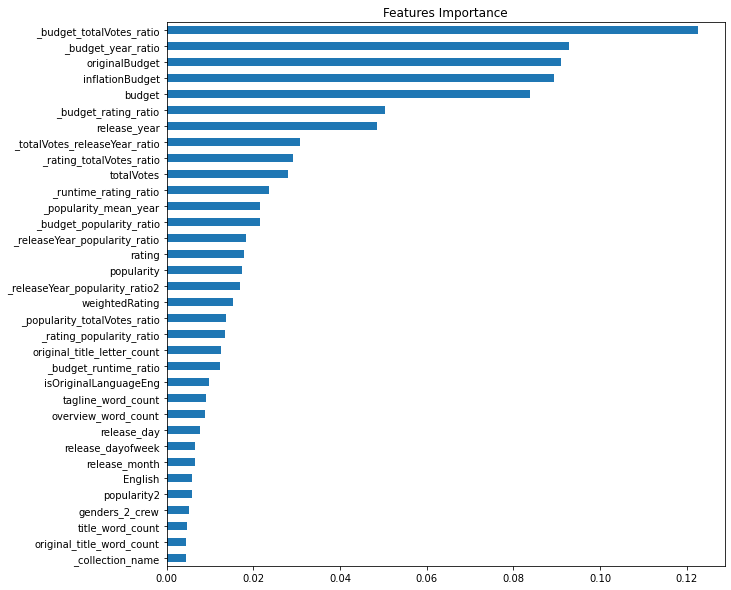

In [25]:
final_err = 0
features = list(train.columns)
feature_importance = pd.DataFrame(index=features)
val_pred = []
val_gold = []
test_pred = pd.DataFrame()

print("CatBoost model")
print("---------------------------")

begin = datetime.now()
for i, (trn, val) in enumerate(fold) :
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_err = []
    
    start = datetime.now()
    result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose=False)
    fold_err.append(result['error'])
    val_pred += list(result['val'])
    val_gold += list(val_y)
    test_pred['fold' + str(i+1)] = result['test']
    feature_importance['fold' + str(i+1)] = result['importance'] / result['importance'].sum()
    print(i + 1, "fold.  RMSE:", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds)) + 's)')
    
    final_err += (sum(fold_err) / len(fold_err))
    
print("---------------------------")
print("fianl avg err.", "{0:.5f}".format(final_err / k), '(' + str(int((datetime.now()-begin).seconds)) + 's)')

val_data = pd.DataFrame({"val_pred":val_pred,"val_gold":val_gold})
val_data.to_csv("CatBoost_val.csv")
test_pred['avg'] = test_pred.mean(axis=1)
test_pred.to_csv("CatBoost_test.csv")
feature_importance['avg'] = feature_importance.mean(axis=1)
feature_importance.mean(axis=1).sort_values()[170:].plot(kind="barh",title = "Features Importance", figsize = (10,10))
feature_importance.to_csv("CatBoost_feature_importance.csv")

In [26]:
XGBoost_val = pd.read_csv('XGBoost_val.csv')
LightGBM_val = pd.read_csv('LightGBM_val.csv')
CatBoost_val = pd.read_csv('CatBoost_val.csv')

XGBoost_test = pd.read_csv('XGBoost_test.csv')
LightGBM_test = pd.read_csv('LightGBM_test.csv')
CatBoost_test = pd.read_csv('CatBoost_test.csv')

weight = {"XGBoost": 0.1,
          "LightGBM": 0.45,
          "CatBoost": 0.45}

val_pred = weight["XGBoost"] * XGBoost_val["val_pred"] + weight["LightGBM"] * LightGBM_val["val_pred"] + weight["CatBoost"] * CatBoost_val["val_pred"]
val_gold = XGBoost_val["val_gold"]
test_pred = weight["XGBoost"] * XGBoost_test["avg"] + weight["LightGBM"] * LightGBM_test["avg"] + weight["CatBoost"] * CatBoost_test["avg"]

print(val_pred)
print()
print("valid final blend err.", np.sqrt(mean_squared_error(val_pred , val_gold)))
print()
print(test_pred)

0       17.018349
1       18.956896
2       15.302754
3       17.189178
4       19.120986
          ...    
4996     8.921942
4997    10.853122
4998    10.800360
4999    14.673780
5000    12.192208
Name: val_pred, Length: 5001, dtype: float64

valid final blend err. 2.175674119805687

0       15.937862
1       14.417882
2       15.606877
3       16.012088
4       13.947738
          ...    
4393    17.418277
4394    17.506716
4395    17.019952
4396    16.615943
4397    12.805089
Name: avg, Length: 4398, dtype: float64


In [27]:
sub = pd.read_csv('../data/sample_submission.csv')
df_sub = pd.DataFrame()
df_sub['id'] = sub['id']
df_sub['revenue'] = np.expm1(test_pred)
#print(df_sub['revenue'])
df_sub.to_csv("../data/submission3.csv", index=False)

后面用不到了

## k-fold 找最佳参数

In [12]:
result_dict = dict()
val_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
features = list(train.columns)
final_err = 0
verbose = False

for i, (trn, val) in enumerate(fold) :
    print(i+1, "fold.    RMSE")
    
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    
    #""" xgboost
    start = datetime.now()
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, features, verbose)
    fold_val_pred.append(result['val']*0.1)
    fold_test_pred.append(result['test']*0.1)
    fold_err.append(result['error'])
    print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds)) + 's)')
    
    #"""
    
    #""" lightgbm
    start = datetime.now()
    result = lgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.45)
    fold_test_pred.append(result['test']*0.45)
    fold_err.append(result['error'])
    print("lgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds)) + 's)')
    #"""
    
    #""" catboost model
    start = datetime.now()
    result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.45)
    fold_test_pred.append(result['test']*0.45)
    fold_err.append(result['error'])
    print("cat model.", "{0:.5f}".format(np.sqrt(result['error'])), '(' + str(int((datetime.now()-start).seconds)) + 's)')
    #"""
    
    # mix result of multiple models
    
    val_pred[val] += np.sum(np.array(fold_val_pred), axis = 0)
    #val_pred[val] += np.array(fold_val_pred).squeeze()

    test_pred += np.sum(np.array(fold_test_pred), axis = 0) 
    #test_pred += np.array(fold_test_pred).squeeze()
    final_err += (sum(fold_err) / len(fold_err))
    
    print("---------------------------")
    print("avg   err.", "{0:.5f}".format(sum(fold_err) / len(fold_err)))
    print("blend err.", "{0:.5f}".format(np.sqrt(mean_squared_error(np.sum(np.array(fold_val_pred), axis = 0),val_y))))
    #print("blend err.", "{0:.5f}".format(rmsle_lgbm(np.array(fold_val_pred).squeeze(),val_y)[1]))
    
     
test_pred /= k
print("fianl avg   err.", final_err / k)
print("fianl blend err.", np.sqrt(mean_squared_error(val_pred , y)))

1 fold.    RMSE
xgb model. 2.17924 (11s)
lgb model. 2.21399 (5s)
cat model. 1.48829 (18s)
---------------------------
avg   err. 1.96051
blend err. 2.19727
2 fold.    RMSE
xgb model. 2.04897 (11s)
lgb model. 2.02751 (6s)
cat model. 1.41952 (28s)
---------------------------
avg   err. 1.83200
blend err. 2.01107
3 fold.    RMSE
xgb model. 2.32394 (29s)
lgb model. 2.35434 (12s)
cat model. 1.52055 (46s)
---------------------------
avg   err. 2.06628
blend err. 2.31435
4 fold.    RMSE
xgb model. 2.32972 (13s)
lgb model. 2.30874 (7s)
cat model. 1.52211 (34s)
---------------------------
avg   err. 2.05352
blend err. 2.30366
5 fold.    RMSE
xgb model. 2.30241 (9s)
lgb model. 2.27954 (5s)
cat model. 1.50747 (24s)
---------------------------
avg   err. 2.02981
blend err. 2.26521
6 fold.    RMSE
xgb model. 1.97450 (12s)
lgb model. 1.95623 (6s)
cat model. 1.39542 (22s)
---------------------------
avg   err. 1.77538
blend err. 1.94150
7 fold.    RMSE
xgb model. 2.45180 (10s)
lgb model. 2.40952 (8s)

In [13]:
print("fianl blend err.", np.sqrt(mean_squared_error(val_pred , y)))

fianl blend err. 2.163973603212282


In [19]:
for i,x in enumerate(np.isinf(train).any()):
    if x:
        print(i)
        print(1)

In [20]:
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        if np.isinf(train.iloc[i,j]):
            print(1)

In [21]:
val_pred

array([17.00841788, 19.13850265, 17.91338534, ..., 11.86539039,
       12.29706318, 16.43274101])

In [22]:
mean_squared_log_error([10000],[200])

15.265707494330004

## 预测测试集

In [14]:
sub = pd.read_csv('../data/sample_submission.csv')
df_sub = pd.DataFrame()
df_sub['id'] = sub['id']
df_sub['revenue'] = np.expm1(test_pred)
#print(df_sub['revenue'])
df_sub.to_csv("../data/submission3.csv", index=False)

In [41]:
test_pred

array([16.77664137, 14.66399992, 15.84457853, ..., 16.99238705,
       16.60800653, 12.71234195])

In [42]:
val_pred

array([17.05834862, 19.16130764, 18.02553931, ..., 11.86955046,
       12.42618707, 16.08135449])

In [49]:
model

NameError: name 'model' is not defined